# 3. Analysis of two sources in the same field of view

This notebook displays the most advanced capabilities of the one-dimensional analysis with DL3 data and `Gammapy` and is also a preview of the capability we would like to achieve with the three-dimensional analysis: to analyse several sources in the field of view at once. 

We will use observations of 1ES1218+304 gathered in 2018 and 2019 to analyse, using the same dataset, this source and 1ES1215+303, that sits in the same field of view. I want to showcase the important simplification of an analysis that, if performed with `MARS`, would have required a few iterations of `selectmc` and `flute`, as well as a careful check of the `flute` settings for the $\theta^2$ cuts and for the position of the OFF regions (in order for them not to overlap with the second source in the field of view). These DL3 data were generated with diffuse MC covering $2.5^{\circ}$ of offset.

Special thanks to Axel (for the data) and Cornelia (for inspiration and advice on the analysis).

In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import PointSkyRegion, CircleSkyRegion
import matplotlib.pyplot as plt
import warnings

from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.data import DataStore, Observation
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

from plot_utils import plot_on_off_regions_skymap, plot_gammapy_sed
from analysis_utils import make_spectrum_dataset

warnings.filterwarnings("ignore")

## 3.1. 1ES1215+303 analysis

The observations, at least in this dataset, were conducted wobbling around the coordinates of 1ES1218+304, with the common offset of $0.4^{\circ}$. This means that, for each of the wobbles (i.e. runs), 1ES1215+303 will sit at different position in the camera. To estimate the background for this source, we want to use OFF regions that are symmetric to the camera center. Not only, we want to be sure that none of this OFF regions will sit on top of 1ES1218+304, otherwise our background estimation will be spoiled. All of these is automatically accounted for by `Gammapy` in the data reduction. Compared to the previous data reduction, we have to specify an additional parameter: an **exclusion region** corresponding to the source that is not of our interest - 1ES1218+304, in this first case. This will prevent the OFF regions used for the background estimation of 1ES1215+303 to sit on 1ES1218+304.

In [2]:
# coordinates of the two sources
_1ES1215_coordinates = SkyCoord.from_name("1ES1215+303", frame="icrs")
_1ES1218_coordinates = SkyCoord.from_name("1ES1218+304", frame="icrs")

# center of the ON region
on_center_1ES1215 = PointSkyRegion(_1ES1215_coordinates)

# create an exclusion mask over 1ES1218+304, in order not to have overlapping OFF regions
exclusion_region_1ES1218 = CircleSkyRegion(
    center=_1ES1218_coordinates,
    radius=0.2 * u.deg,
)

For `Gammapy` to understand how the exclusion region a `Geometry` (a `WcsGeom`) has to be created. This is basically a skymap needed to convert the exclusion region in a set of pixels that can be then used to check whether the OFF regions (also converted into pixels in the skymap) overlap with it. We center our skymap on our source of interest: 1ES1215+303.

In [3]:
# create the geometry and add the energy axes
# geometry to be used in all the skymaps
skymap_geom_1ES1215 = WcsGeom.create(
    skydir=_1ES1215_coordinates, binsz=0.05, width="5 deg", frame="icrs", proj="TAN"
)
exclusion_mask_1ES1218 = ~skymap_geom_1ES1215.region_mask([exclusion_region_1ES1218])

# define the energy axes
energy_min = 10 * u.GeV
energy_max = 1e5 * u.GeV
n_energy_est_bins = 20
n_energy_true_bins = 28

energy_axis = MapAxis.from_energy_bounds(
    energy_min,
    energy_max,
    n_energy_est_bins,
    per_decade=False,
    unit="GeV",
    name="energy",
)
energy_true_axis = MapAxis.from_energy_bounds(
    energy_min,
    energy_max,
    n_energy_true_bins,
    per_decade=False,
    unit="GeV",
    name="energy_true",
)

# and the geometry of the ON region
geom_on_region_1ES1215 = RegionGeom.create(region=on_center_1ES1215, axes=[energy_axis])
# pick a number of OFF regions to be used
n_off_regions = 2

In [4]:
datastore = DataStore.from_dir("data/1ES1218+304/dl3")
observations = datastore.get_observations(required_irf=["rad_max", "aeff", "edisp"])

02/17/2024 12:44:52 PM|INFO|gammapy.data.data_store|Observations selected: 76 out of 76.


Notice that, having used diffuse MC, we have IRF components whose values also depends from the offset (in previous cases the offset dependence was just one thin offset bin centred on $0.4^{\circ}$).

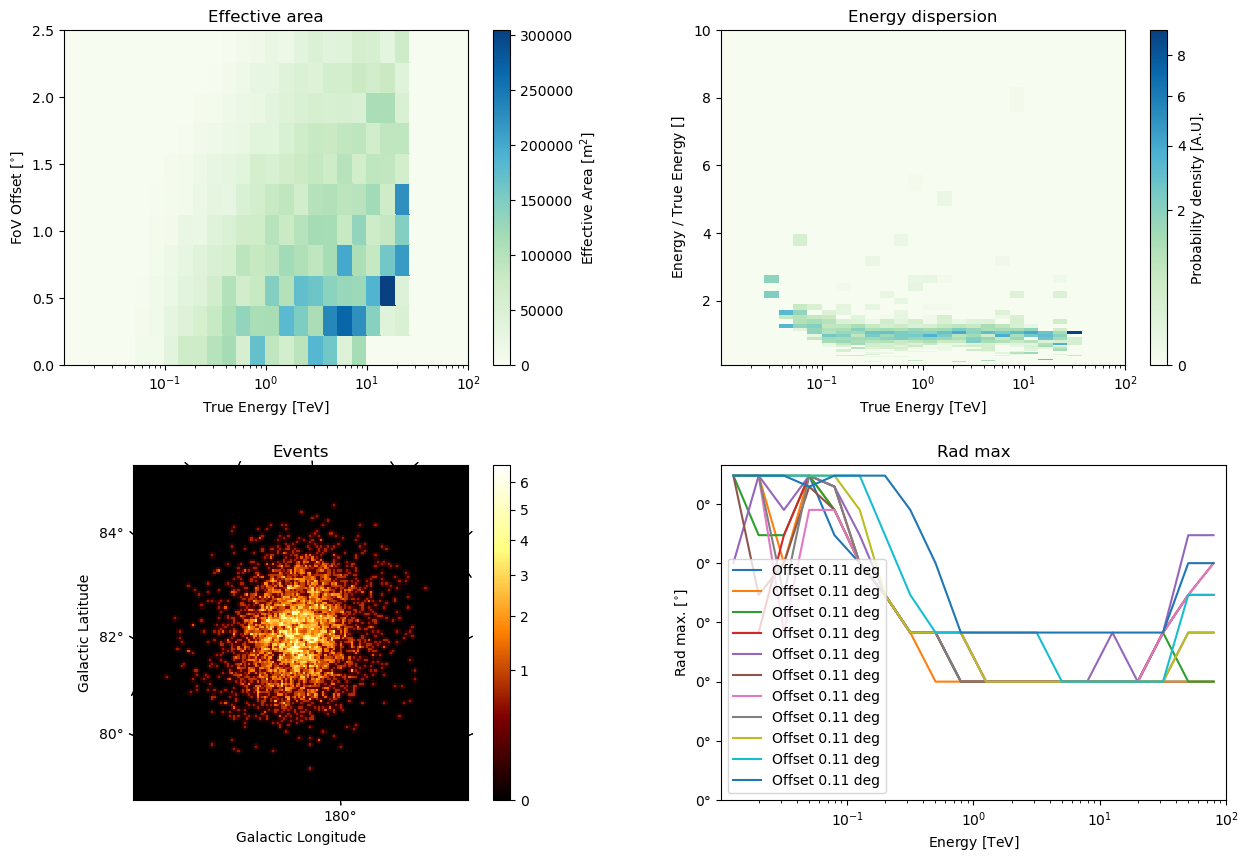

In [5]:
observations[0].peek()

I created a function, `plot_on_off_regions_skymap` in `plot_utils.py`, to illustrate how the positions of the two sources is changing in the camera frame and how we are placing the ON, OFF, and exclusion regions.

02/17/2024 12:44:55 PM|INFO|plot_utils|making ON and OFF regions skymap plot for run 5071624
02/17/2024 12:44:56 PM|INFO|plot_utils|making ON and OFF regions skymap plot for run 5078101
02/17/2024 12:44:56 PM|INFO|plot_utils|making ON and OFF regions skymap plot for run 5078103


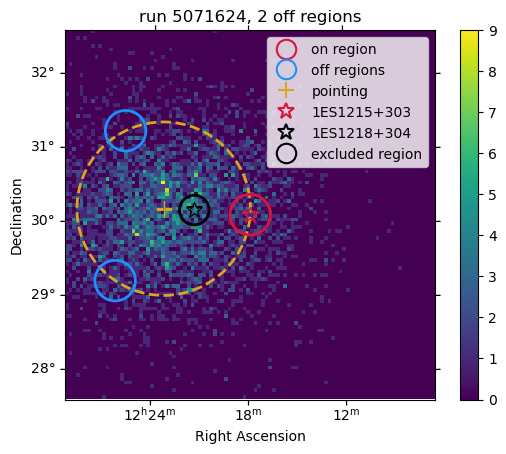

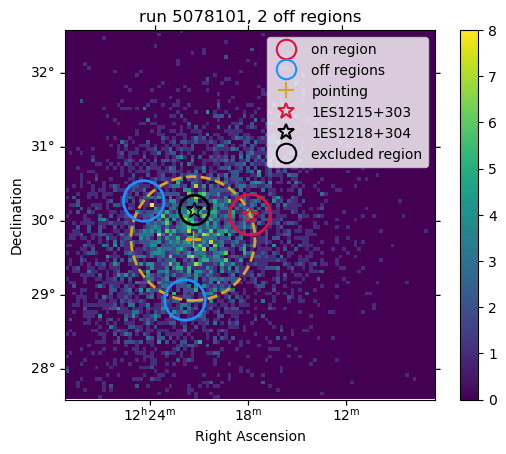

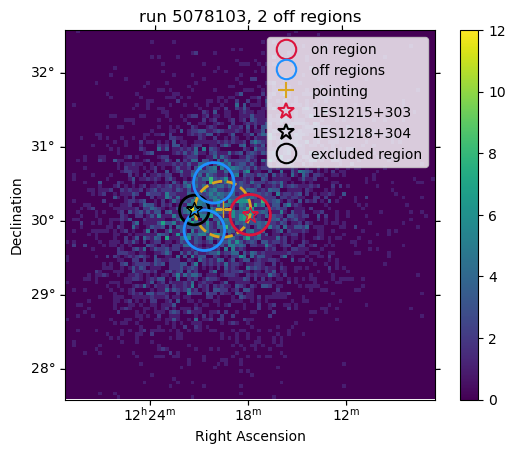

In [6]:
for observation in (observations[0], observations[2], observations[4]):
    plot_on_off_regions_skymap(
        observation=observation,
        skymap_geom=skymap_geom_1ES1215,
        source_coords=_1ES1215_coordinates,
        exclusion_region_center=exclusion_region_1ES1218.center,
        exclusion_region_radius=exclusion_region_1ES1218.radius,
        n_off_regions=n_off_regions,
        source_name="1ES1215+303",
        excluded_source_name="1ES1218+304",
    )

In [7]:
dataset_1ES1215 = make_spectrum_dataset(
    observations=observations,
    n_off_regions=n_off_regions,
    geom_on_region=geom_on_region_1ES1215,
    energy_true_axis=energy_true_axis,
    exclusion_mask=exclusion_mask_1ES1218,
)

02/17/2024 12:44:58 PM|INFO|analysis_utils|reducing run 5071624
02/17/2024 12:44:59 PM|INFO|analysis_utils|reducing run 5071627
02/17/2024 12:45:00 PM|INFO|analysis_utils|reducing run 5078101
02/17/2024 12:45:00 PM|INFO|analysis_utils|reducing run 5078102
02/17/2024 12:45:01 PM|INFO|analysis_utils|reducing run 5078103
02/17/2024 12:45:01 PM|INFO|analysis_utils|reducing run 5078104
02/17/2024 12:45:02 PM|INFO|analysis_utils|reducing run 5078105
02/17/2024 12:45:02 PM|INFO|analysis_utils|reducing run 5078106
02/17/2024 12:45:03 PM|INFO|analysis_utils|reducing run 5078107
02/17/2024 12:45:03 PM|INFO|analysis_utils|reducing run 5078108
02/17/2024 12:45:04 PM|INFO|analysis_utils|reducing run 5078109
02/17/2024 12:45:04 PM|INFO|analysis_utils|reducing run 5078110
02/17/2024 12:45:05 PM|INFO|analysis_utils|reducing run 5078145
02/17/2024 12:45:05 PM|INFO|analysis_utils|reducing run 5078146
02/17/2024 12:45:06 PM|INFO|analysis_utils|reducing run 5078147
02/17/2024 12:45:06 PM|INFO|analysis_uti

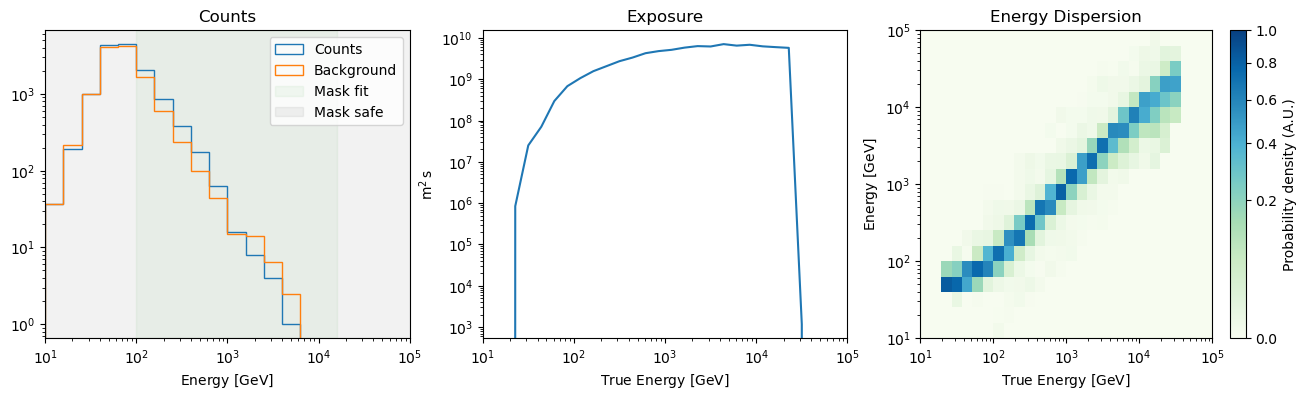

In [8]:
# apply proper minimum and maximum energy for the fit, display the result
e_min = 80 * u.GeV
e_max = 20 * u.TeV
dataset_1ES1215.mask_fit = dataset_1ES1215.counts.geom.energy_mask(e_min, e_max)
dataset_1ES1215.peek()

In [9]:
# perform the fit
# choose the mode
spectral_model_1ES1215 = PowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    reference=200 * u.GeV,
)
model_1ES1215 = SkyModel(spectral_model=spectral_model_1ES1215, name="1ES1215+303")
# assign it
dataset_1ES1215.models = [model_1ES1215]

In [10]:
fit = Fit()
results = fit.run(datasets=dataset_1ES1215)
print(results)
print(spectral_model_1ES1215)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 56
	total stat : 20.49

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

PowerLawSpectralModel

  type      name     value         unit        error   min max frozen is_norm link
-------- --------- ---------- -------------- --------- --- --- ------ ------- ----
spectral     index 3.2868e+00                1.018e-01 nan nan  False   False     
spectral amplitude 1.2445e-10 TeV-1 s-1 cm-2 9.295e-12 nan nan  False    True     
spectral reference 2.0000e+02            GeV 0.000e+00 nan nan   True   False     


In [11]:
# compute flux points
energy_edges = energy_axis.edges[4:-6]
flux_points_estimator = FluxPointsEstimator(
    energy_edges=energy_edges, source="1ES1215+303", selection_optional="all"
)
flux_points_1ES1215 = flux_points_estimator.run(datasets=dataset_1ES1215)

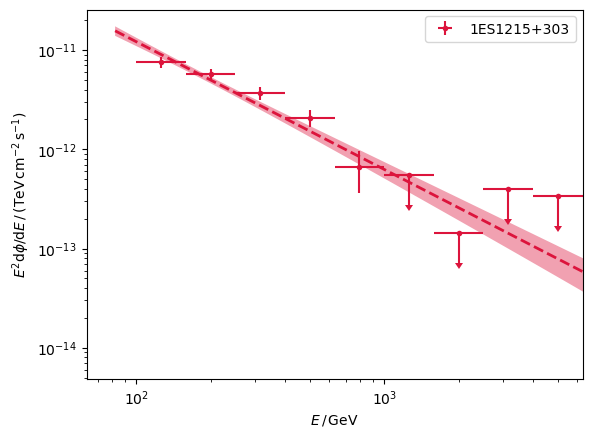

In [12]:
# make a plot of the spectrum
fig, ax = plt.subplots()
plot_gammapy_sed(
    ax,
    spectral_model_1ES1215,
    flux_points_1ES1215,
    e_min,
    e_max,
    "crimson",
    "1ES1215+303",
)
ax.legend()
plt.show()

## 3.1. 1ES1218+304 analysis

We now analyse the source around which the wobble observations were performed, `1ES1218+304`. 
Now the OFF regions will always sit on a circle of radius $0.4^{\circ}$, we just have to be sure, by using the exclusion region, none of them sits on `1ES1215+303`.

In [13]:
# center of the ON region
on_center_1ES1218 = PointSkyRegion(_1ES1218_coordinates)

# create an exclusion mask over 1ES1215+303, in order not to have overlapping OFF regions
exclusion_region_1ES1215 = CircleSkyRegion(
    center=_1ES1215_coordinates,
    radius=0.2 * u.deg,
)

In [14]:
# create the geometry and add the energy axes
# geometry to be used in all the skymaps
skymap_geom_1ES1218 = WcsGeom.create(
    skydir=_1ES1218_coordinates, binsz=0.05, width="5 deg", frame="icrs", proj="TAN"
)
exclusion_mask_1ES1215 = ~skymap_geom_1ES1218.region_mask([exclusion_region_1ES1215])

# the energy axes we have from before
# and the geometry of the ON region
geom_on_region_1ES1218 = RegionGeom.create(region=on_center_1ES1218, axes=[energy_axis])
# pick a number of OFF regions to be used
n_off_regions = 2

Let us check how the ON, OFF, and exclusion regions are arranged now.

02/17/2024 12:45:50 PM|INFO|plot_utils|making ON and OFF regions skymap plot for run 5071624
02/17/2024 12:45:50 PM|INFO|plot_utils|making ON and OFF regions skymap plot for run 5078101
02/17/2024 12:45:50 PM|INFO|plot_utils|making ON and OFF regions skymap plot for run 5078103


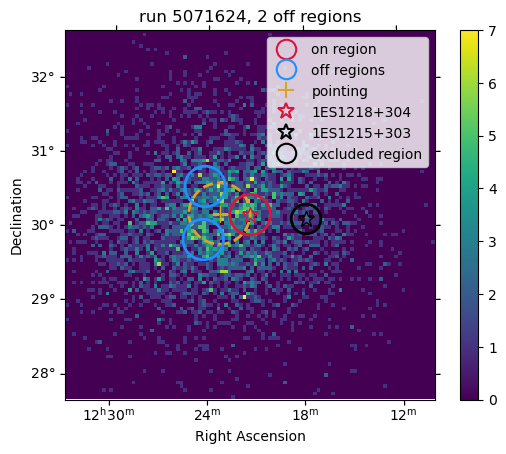

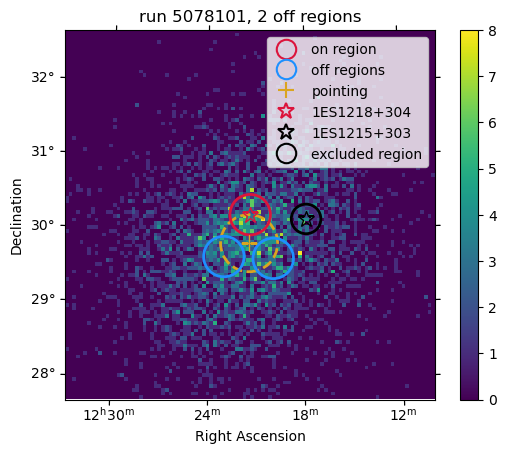

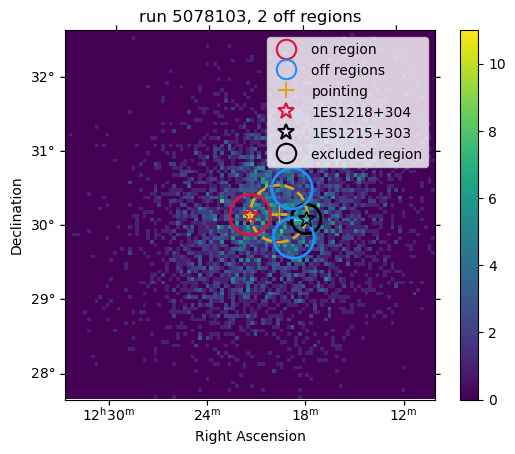

In [15]:
for observation in (observations[0], observations[2], observations[4]):
    plot_on_off_regions_skymap(
        observation=observation,
        skymap_geom=skymap_geom_1ES1218,
        source_coords=_1ES1218_coordinates,
        exclusion_region_center=exclusion_region_1ES1215.center,
        exclusion_region_radius=exclusion_region_1ES1215.radius,
        n_off_regions=n_off_regions,
        source_name="1ES1218+304",
        excluded_source_name="1ES1215+303",
    )

In [16]:
dataset_1ES1218 = make_spectrum_dataset(
    observations=observations,
    n_off_regions=n_off_regions,
    geom_on_region=geom_on_region_1ES1218,
    energy_true_axis=energy_true_axis,
    exclusion_mask=exclusion_mask_1ES1215,
)

02/17/2024 12:45:52 PM|INFO|analysis_utils|reducing run 5071624
02/17/2024 12:45:53 PM|INFO|analysis_utils|reducing run 5071627
02/17/2024 12:45:53 PM|INFO|analysis_utils|reducing run 5078101
02/17/2024 12:45:54 PM|INFO|analysis_utils|reducing run 5078102
02/17/2024 12:45:54 PM|INFO|analysis_utils|reducing run 5078103
02/17/2024 12:45:55 PM|INFO|analysis_utils|reducing run 5078104
02/17/2024 12:45:55 PM|INFO|analysis_utils|reducing run 5078105
02/17/2024 12:45:56 PM|INFO|analysis_utils|reducing run 5078106
02/17/2024 12:45:56 PM|INFO|analysis_utils|reducing run 5078107
02/17/2024 12:45:57 PM|INFO|analysis_utils|reducing run 5078108
02/17/2024 12:45:57 PM|INFO|analysis_utils|reducing run 5078109
02/17/2024 12:45:57 PM|INFO|analysis_utils|reducing run 5078110
02/17/2024 12:45:58 PM|INFO|analysis_utils|reducing run 5078145
02/17/2024 12:45:58 PM|INFO|analysis_utils|reducing run 5078146
02/17/2024 12:45:59 PM|INFO|analysis_utils|reducing run 5078147
02/17/2024 12:45:59 PM|INFO|analysis_uti

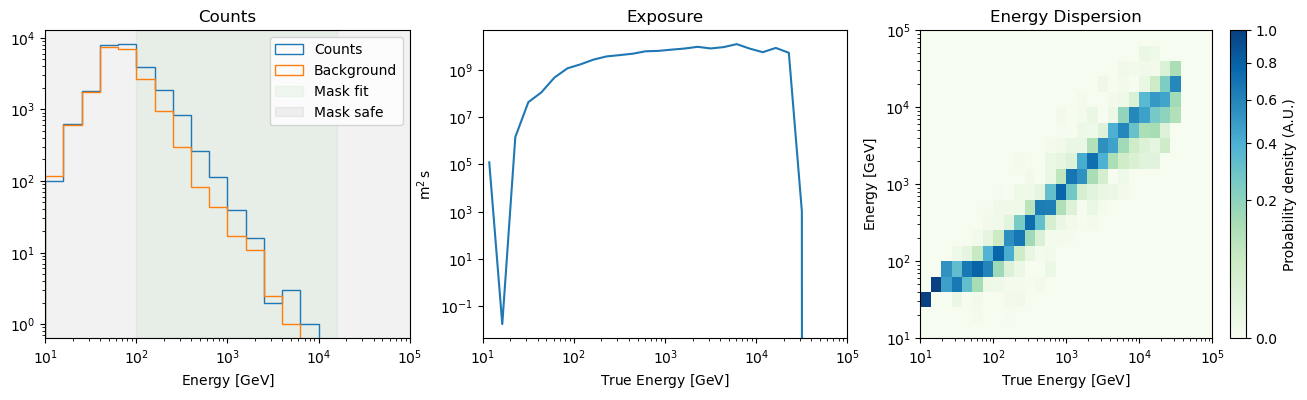

In [17]:
# apply proper minimum and maximum energy for the fit
e_min = 80 * u.GeV
e_max = 20 * u.TeV
dataset_1ES1218.mask_fit = dataset_1ES1218.counts.geom.energy_mask(e_min, e_max)

dataset_1ES1218.peek()

In [18]:
# assign the model
spectral_model_1ES1218 = PowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    reference=200 * u.GeV,
)
model_1ES1218 = SkyModel(spectral_model=spectral_model_1ES1218, name="1ES1218+304")
dataset_1ES1218.models = [model_1ES1218]

In [19]:
fit = Fit()
results = fit.run(datasets=dataset_1ES1218)
print(results)
print(spectral_model_1ES1218)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 118
	total stat : 59.30

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

PowerLawSpectralModel

  type      name     value         unit        error   min max frozen is_norm link
-------- --------- ---------- -------------- --------- --- --- ------ ------- ----
spectral     index 3.0773e+00                4.193e-02 nan nan  False   False     
spectral amplitude 2.4780e-10 TeV-1 s-1 cm-2 7.728e-12 nan nan  False    True     
spectral reference 2.0000e+02            GeV 0.000e+00 nan nan   True   False     


In [20]:
# compute flux points
energy_edges = energy_axis.edges[4:-6]
flux_points_estimator = FluxPointsEstimator(
    energy_edges=energy_edges, source="1ES1218+304", selection_optional="all"
)
flux_points_1ES1218 = flux_points_estimator.run(datasets=dataset_1ES1218)

As a final step, we plot the spectra of the two sources together.

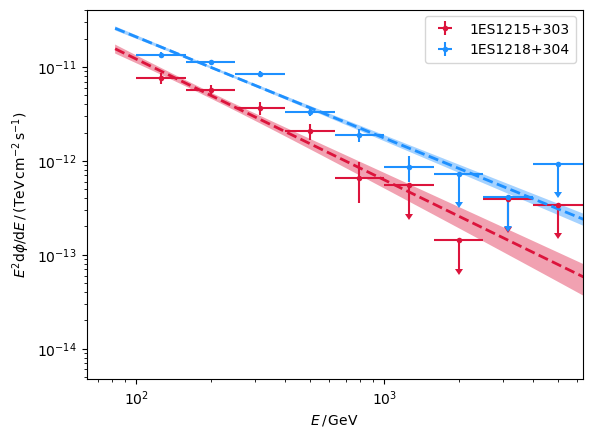

In [21]:
# make a plot of the spectrum
fig, ax = plt.subplots()
plot_gammapy_sed(
    ax,
    spectral_model_1ES1215,
    flux_points_1ES1215,
    e_min,
    e_max,
    "crimson",
    "1ES1215+303",
)
plot_gammapy_sed(
    ax,
    spectral_model_1ES1218,
    flux_points_1ES1218,
    e_min,
    e_max,
    "dodgerblue",
    "1ES1218+304",
)
ax.legend()
plt.show()